In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
avg_year = pd.read_csv('average_bi_yearly_733_flu_rate_4383.csv',header=None)

In [4]:
avg_year.head()

,0,1
0,2005-08-24,4.371718
1,2005-08-25,4.152848
2,2005-08-26,3.971144
3,2005-08-27,3.941716
4,2005-08-28,3.912292


In [5]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [6]:
y.head()

,0
Date,
2005-08-24,3.12857
2005-08-25,3.23000
2005-08-26,3.23714
2005-08-27,3.24429
2005-08-28,3.25143


In [7]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Date,,,,,,,,,,,,,,,,,,,,,
2005-08-24,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2005-08-25,2441.453870,162.536869,0.0,0.0,162.014142,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162.291446,0.0
2005-08-26,1528.220180,176.061535,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2005-08-27,405.029314,0.000000,0.0,0.0,301.983868,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2005-08-28,1683.808180,474.855717,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,318.406892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [8]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries, ARIAMA only consider y, setting X has no effect
X = X.iloc[:, 0: 500]

# first with the last year as test
# use the last 365 of training set as validation set
test_size =365
val_size=365
length = X.shape[0]
train1_X = X[0:length-test_size*2]
val1_X = X[length-test_size*2:length-test_size]
train1_y = y[0:length-test_size*2]
val1_y = y[length-test_size*2:length-test_size]
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]

# second with the last 2 year as test
test_size2 =365*2
train2_X = X[0:length-test_size2-val_size]
val2_X = X[length-test_size2-val_size:length-test_size2]
train2_y = y[0:length-test_size2-val_size]
val2_y = y[length-test_size2-val_size:length-test_size2]
test2_X = X[length-test_size2:]
test2_y = y[length-test_size2:]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]


print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3653, 500)  train1 y: (3653, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
train2 X: (3288, 500)  train2 y: (3288, 1)  Test2 X: (730, 500)  Test2 y: (730, 1)


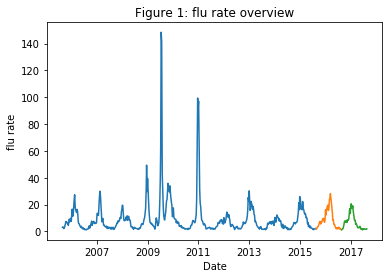

In [9]:
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = train1_y.copy()
df['y'] = train1_y.values

fig, ax = plt.subplots()
ax.plot(date[:3653],df.y,date[3653:4018],y.values[3653:4018],date[4018:],y.values[4018:])
plt.title("Figure 1: flu rate overview")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [10]:
df1 = avg_year.copy()
#df1['rate'] = train1_y2
df1.head()

,0,1
0,2005-08-24,4.371718
1,2005-08-25,4.152848
2,2005-08-26,3.971144
3,2005-08-27,3.941716
4,2005-08-28,3.912292


In [11]:
df=df1.iloc[:,1:2].copy()

In [12]:
df.head()

,1
0,4.371718
1,4.152848
2,3.971144
3,3.941716
4,3.912292


In [13]:
df3 = df[:4018].copy()
df4 = df[4018:].copy()

In [21]:
# the above plot shows the possible significant AR term may be 5
# anyway, just tune the possible choices
from statsmodels.tsa.arima_model import ARIMA
# fit model
model=ARIMA(endog=train1_y2.values,exog=df3,order=[2,1,14])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4017
Model:                ARIMA(2, 1, 14)   Log Likelihood               -1499.350
Method:                       css-mle   S.D. of innovations              0.350
Date:                Mon, 30 Jul 2018   AIC                           3036.700
Time:                        06:34:25   BIC                           3156.367
Sample:                             1   HQIC                          3079.110
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0863      0.038      2.278      0.023       0.012       0.161
x1            -0.0092      0.004     -2.292      0.022      -0.017      -0.001
ar.L1.D.y      1.0061      0.040     25.021      0.0

In [22]:
model=ARIMA(endog=train1_y2.values,
            exog=df3,
            order=[1,2,15])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 4016
Model:                ARIMA(1, 2, 15)   Log Likelihood               -1534.490
Method:                       css-mle   S.D. of innovations              0.353
Date:                Mon, 30 Jul 2018   AIC                           3106.981
Time:                        06:36:22   BIC                           3226.644
Sample:                             2   HQIC                          3149.390
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0033      0.001      2.324      0.020       0.001       0.006
x1             -0.0004      0.000     -2.329      0.020      -0.001   -5.57e-05
ar.L1.D2.y      0.0104        nan        nan    

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [26]:
## now model selection via AIC
def evaluate_arima_model2(dataset,X, p,d,q):
    # fit model
    model = ARIMA(dataset.values,exog=X,order=(p,d,q))
    model_fit = model.fit(disp=0)
  
    error = model_fit.aic
    return error


## tune the parameters by rmse
def evaluate_models2(dataset,X, p_values, d_values, q_values):
    best_score=1000000000
    p0=-1
    d0=-1
    q0=-1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    aic = evaluate_arima_model2(dataset,X, p,d,q)
                    if aic < best_score:
                        best_score = aic
                        p0=p
                        d0=d
                        q0=q
                    print(p,',',d,',',q,' AIC:',aic)
                except:
                    continue
    print('Best ARIMA (',p0,',',d0,',',q0,') AIC:',best_score)


In [27]:
p_values = [2]
d_values = [1]
q_values = [15]
df3 = df1.values[:4018]
evaluate_models2(train1_y2,df3, p_values, d_values, q_values)

Best ARIMA ( -1 , -1 , -1 ) AIC: 1000000000


In [28]:
p_values = [2]
d_values = [1]
q_values = [14]
df3 = df1.values[:4018]
evaluate_models2(train1_y2,df3, p_values, d_values, q_values)

Best ARIMA ( -1 , -1 , -1 ) AIC: 1000000000


In [14]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

train1 = train1_y2.values
test1 = test1_y.values

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.statespace.SARIMAX(endog =train1,
                                  exog=df3,
                                  trend='n', order=(2,1,14),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
training_res = training_mod.fit()
training_mod.fit(disp=0)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
train1 = train1_y2.values
test1 = test1_y.values

df3 = df[:4018].copy()
df4 = df[4018:].copy()

history = [x for x in train1]
predict = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4.iloc[[t]]
    output = model_fit.forecast(steps=1,exog=exog_test)
    yhat = output.values[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.1787618721479367
1
1.1172943252915137
2
1.103842258842071
3
1.1868865891861973
4
1.2196315203737673
5
1.2516485405530227
6
1.29096016249929
7
1.3187516192757927
8
1.3555643123923717
9
1.3761861982020165
10
1.5180714504751573
11
1.601875552666882
12
1.6742839418705
13
1.7646431102124904
14
1.8417975878017498
15
1.9236189212707553
16
1.9500777773698221
17
1.961989418535441
18
1.9839744059194946
19
1.9938630375855577
20
2.0197621381025206
21
2.0333703584547633
22
2.053134633160641
23
2.050693675397361
24
2.437022448992943
25
2.630556263124983
26
2.817480358578902
27
3.0170621398614488
28
3.204949111634303
29
3.398815820813699
30
3.4832933343926764
31
3.9153433585577444
32
4.1711059957060925
33
4.421482339468878
34
4.687764426663927
35
4.943310113019215
36
5.20155374000323
37
5.277705560260371
38
5.874211552448044
39
6.21365319002814
40
6.545090482369099
41
6.890075238960975
42
7.222702914831182
43
7.563884714454138
44
7.6795813477208235
45
7.589967493183054
46
7.606960797855709
47
7.613

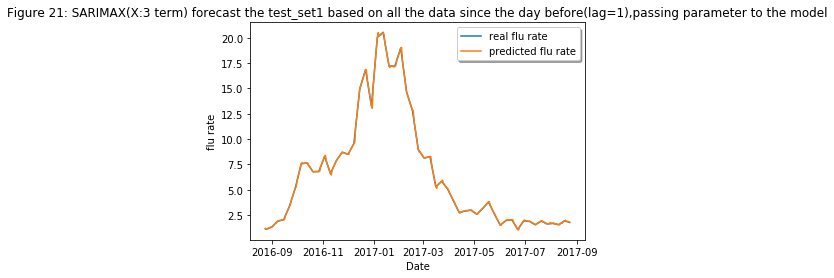

In [16]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 21: SARIMAX(X:3 term) forecast the test_set1 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [18]:
## lag=5
train1 = train1_y2.values[:4018-4]
test = y.values[4018-4:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018-4:].copy()

history = [x for x in train1]
predict2 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018-4+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+5]
    output = model_fit.forecast(steps=5,exog=exog_test)
    yhat = output.values[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.5471180595042267
1
1.4928850793425406
2
1.4836994793850065
3
1.481094210127252
4
1.4521793364997824
5
1.4393743701054162
6
1.4301831127446853
7
1.6882498146880647
8
1.7108093701842098
9
1.7260272720005492
10
1.7541082293199097
11
1.7576112722782917
12
1.7890315396238443
13
1.811831412608978
14
2.178175713740271
15
2.25423220575504
16
2.2604108414138135
17
2.3150791534246262
18
2.3282029043578336
19
2.357748828708993
20
2.388392314626974
21
2.3724131100604273
22
2.3865789172088956
23
2.3586581933304727
24
2.376494780392143
25
2.3612171201102368
26
2.368366970351994
27
2.373638320090979
28
3.484199758733616
29
3.6682211557546247
30
3.7377744739172143
31
3.8405326468027017
32
3.9090510454569816
33
3.99494302632696
34
4.07612414936918
35
5.140661594970822
36
5.370414402702348
37
5.427495048483605
38
5.526576836458394
39
5.59165374765398
40
5.666458863835571
41
5.744105231753383
42
7.303893968555499
43
7.628665342051745
44
7.722836061039098
45
7.852652295582919
46
7.950155766183203
47
8.0

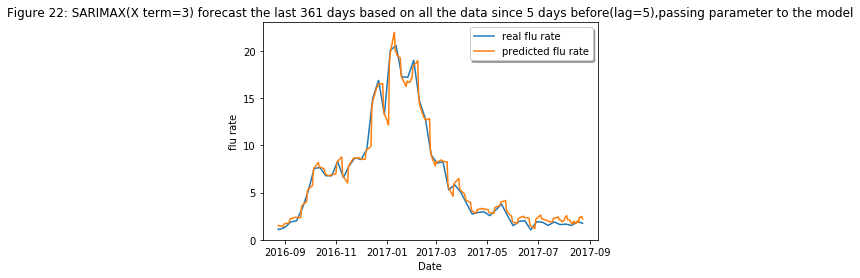

In [19]:
## lag=5
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 22: SARIMAX(X term=3) forecast the last 361 days based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [20]:
## lag=10
train1 = train1_y2.values[:4018-9]
test = y.values[4018-9:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018-9:].copy()

history = [x for x in train1]
predict3 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018-9+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+10]
    output = model_fit.forecast(steps=10,exog=exog_test)
    yhat = output.values[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

2.5477939780510335
1
2.5343294080054406
2
2.5223777907720333
3
2.550862678617358
4
2.569942734157287
5
2.3570736860264794
6
2.356159638734491
7
2.347304558458741
8
2.3437667865053946
9
2.3171425625721924
10
2.3159057318225904
11
2.318653947800125
12
2.6748576996257714
13
2.676554502666501
14
2.6900336523480437
15
2.720233072083438
16
2.690803042222151
17
2.7102714789802307
18
2.7142138275605205
19
3.1740702185041876
20
3.193522573657554
21
3.1930043944788933
22
3.2583022443335143
23
3.2295760904970416
24
3.2350537916143587
25
3.237732235751717
26
3.1819286170615206
27
3.1750319430285487
28
3.1423957145342296
29
3.1734092615791565
30
3.154471372177952
31
3.1749049586951914
32
3.187885080105643
33
4.664404597278498
34
4.727672639245645
35
4.7838429061257255
36
4.880629871760652
37
4.83789465815069
38
4.8330052794323075
39
4.822256729256716
40
6.1207843746089665
41
6.150923248251361
42
6.1970432738576955
43
6.301015192687979
44
6.277910646797651
45
6.272917701112382
46
6.272455867123555
4

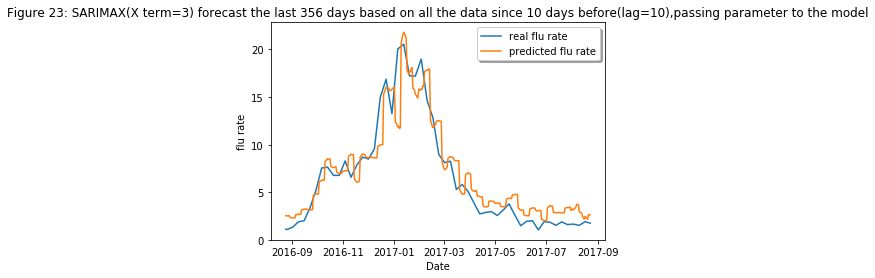

In [21]:
# visualize lag=10
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 23: SARIMAX(X term=3) forecast the last 356 days based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [22]:
## lag=14
train1 = train1_y2.values[:4018-13]
test = y.values[4018-13:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018-13:].copy()
history = [x for x in train1]
predict4 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018-13+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+14]
    output = model_fit.forecast(steps=14,exog=exog_test)
    yhat = output.values[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

3.9279814257664145
1
3.9187333153711306
2
3.3409246038705747
3
3.3348191176662283
4
3.3468887427515157
5
3.369680819416433
6
3.357084113151087
7
3.3850509174212595
8
3.4006871270669246
9
3.177838126030509
10
3.1859954545305684
11
3.1923094051327934
12
3.2008881322909115
13
3.1698969547763767
14
3.170245448867921
15
3.171209648056202
16
3.5423550425803594
17
3.521575445565022
18
3.515980103242819
19
3.5280568100735312
20
3.5001438930404847
21
3.523939580396305
22
3.527211929376692
23
4.001713653291303
24
3.991559963681084
25
3.9618289692683706
26
4.003608175494294
27
3.977048252718719
28
3.9847286535423763
29
3.988828526663263
30
3.93181823550961
31
3.929906791857052
32
3.901251266627503
33
3.938475782515337
34
3.92028082566429
35
3.942352269066266
36
3.953761156959061
37
5.479058179132751
38
5.446484008180608
39
5.409764580303714
40
5.4183753575831
41
5.37926116188508
42
5.377228466955587
43
5.366708851820391
44
6.713973508655365
45
6.657757529654815
46
6.626011731449771
47
6.659697836

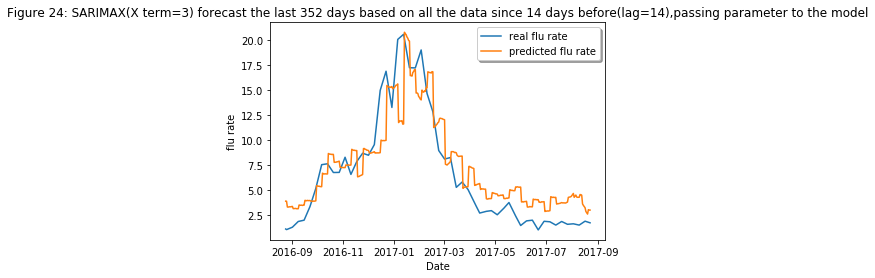

In [23]:
# visualize lag=14
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 24: SARIMAX(X term=3) forecast the last 352 days based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [25]:
## lag=28
train1 = train1_y2.values[:4018-27]
test = y.values[4018-27:]
test1 = test1_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:4018].copy()
df4 = df[4018-27:].copy()


history = [x for x in train1]
predict5 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:4018-27+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+28]
    output = model_fit.forecast(steps=28,exog=exog_test)
    yhat = output.values[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

6.480952812897353
1
6.4655420619946025
2
5.815801017544991
3
5.810531322974703
4
5.820827527607242
5
5.841583202979876
6
5.83832576828803
7
5.858417963905784
8
5.875312204784364
9
6.0191083040155675
10
6.024627721292374
11
6.025464963679267
12
6.021879568049997
13
5.997712131060849
14
5.998309471066751
15
5.992633125336902
16
5.648804538790069
17
5.64481723589337
18
5.653233110252672
19
5.667684343960206
20
5.660911285069299
21
5.679328380076249
22
5.690165356047234
23
5.553856604440785
24
5.561950279033724
25
5.565297547656744
26
5.573116469141256
27
5.559123433407469
28
5.563070766071394
29
5.567298208334739
30
5.789186355378228
31
5.782017712056125
32
5.782042165771849
33
5.79039352379357
34
5.776868156126552
35
5.79500320026943
36
5.800417759545249
37
6.075405929276199
38
6.070671982581124
39
6.055100907131823
40
6.079542468882581
41
6.066411849048234
42
6.0705089425257635
43
6.072086785328161
44
6.04360188819613
45
6.039292550692357
46
6.020194866794474
47
6.0419960871264715
48
6.

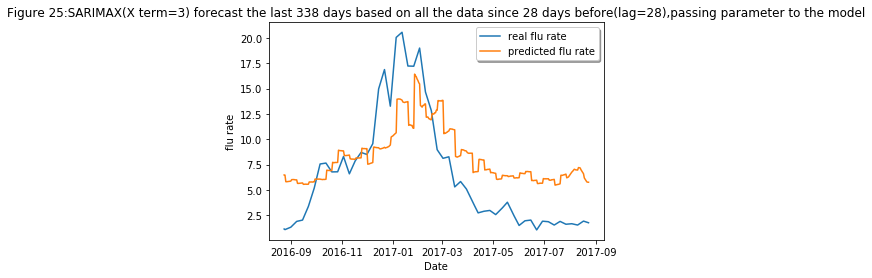

In [26]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 25:SARIMAX(X term=3) forecast the last 338 days based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()